In [20]:
from vizdoom import *
import random
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2 as cv
from skimage import transform
from utility import *

from agent import DQN_agent
import torch
from torch.autograd import Variable
from tensorboardX import SummaryWriter

writer = SummaryWriter(log_dir = 'runs/defend_the_center')

game = DoomGame()
# change this for vizdoom defend_the_center path
game.load_config("../../../Udacity/doom/scenarios/defend_the_center.cfg")
game.set_screen_format(ScreenFormat.GRAY8)
game.add_available_game_variable(GameVariable.KILLCOUNT)
game.init()

print(game.get_available_buttons())

agent = DQN_agent(len(actions), device, writer, is_dueling=True)


[Button.TURN_LEFT, Button.TURN_RIGHT, Button.ATTACK]
Creating dueling network


In [2]:
prepopulate_buffer(game, agent)

prepopulation start
0


D:\Anaconda\envs\drlnd\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
D:\Anaconda\envs\drlnd\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
prepopulation stop


In [3]:
from collections import deque

eps_start=1.0
eps_end=0.01
eps_decay=0.995

epsilon = eps_start

results = deque(maxlen=10)
cx = Variable(torch.zeros(64, 40, device=device)) # the cell states of the LSTM are reinitialized to zero
hx = Variable(torch.zeros(64, 40, device=device)) # the hidden states of the LSTM are reinitialized to 
episode = 0
max_reward =0
while True:
    episode+=1
    game.new_episode()
    last_total_health = 100
    last_ammo = game.get_game_variable(GameVariable.AMMO2)
    while True:
        next_state = state = game.get_state()
        starting_state = state.screen_buffer
        discounted_reward = 0
        for i in range(params.n_steps):
            state = next_state
            img = state.screen_buffer
            img = preprocess_frame(img)
            health_delta = game.get_game_variable(GameVariable.HEALTH) - last_total_health
            last_total_health = game.get_game_variable(GameVariable.HEALTH)
        
            ammo_delta = game.get_game_variable(GameVariable.AMMO2) - last_ammo
            last_ammo = game.get_game_variable(GameVariable.AMMO2)
                
            selected_action = agent.select_action(img, epsilon, (hx[0].view(1,-1), cx[0].view(1,-1)))
            if i == 0:
                first_action = selected_action
            action = actions[selected_action]
            reward = game.make_action(action)
            discounted_reward += (params.gamma**i)*(reward+healthReward(health_delta)+ammoReward(ammo_delta))
            done = game.is_episode_finished()
            if done:
                break
            next_state = game.get_state()
        if done:
            cx = Variable(torch.zeros(64, 40, device=device)) # the cell states of the LSTM are reinitialized to zero
            hx = Variable(torch.zeros(64, 40, device=device)) # the hidden states of the LSTM are reinitialized to zero
            next_img = np.zeros((84, 84), dtype='uint8')
            (hx, cx) = agent.step(episode, preprocess_frame(starting_state), first_action, discounted_reward , next_img, done, hx, cx)
            break
        else:
            cx = Variable(cx.data) # we keep the old cell states, making sure they are in a torch variable
            hx = Variable(hx.data) # we keep the old hidden states, making sure they are in a torch variable
        next_img = next_state.screen_buffer
        next_img = preprocess_frame(next_img)
        (hx, cx) = agent.step(episode, preprocess_frame(starting_state), first_action, discounted_reward , next_img, done, hx, cx)
        state = next_state
    # epsilon decay
    epsilon = epsilon*eps_decay
    if epsilon < eps_end:
        epsilon = eps_end
    # save each 500 episodes
    if episode%500==0:
        file_name = 'checkpoint_' + str(episode) + '.pth'
        torch.save(agent.local_network.state_dict(), file_name)
    if game.get_total_reward()> max_reward:
        max_reward = game.get_total_reward()
    results.append(game.get_total_reward())
    writer.add_scalar('Game variables/Kills', game.get_game_variable(GameVariable.KILLCOUNT), episode)
    if episode>=100:
        writer.add_scalar('Reward Loss/Reward', np.mean(results), episode)
    if episode>=10 and episode%100==0:
        print ("    ", episode, "mean result:", np.mean(results), " epsilon = ", epsilon, " reward: ", game.get_total_reward(), " max reward = " , max_reward)
    if np.mean(results)>= 20:
        print("Congratulations, your AI wins in episode ", episode)
        break

     100 mean result: 1.8  epsilon =  0.6057704364907278  reward:  5.0  max reward =  5.0
     200 mean result: 6.3  epsilon =  0.3669578217261671  reward:  9.0  max reward =  11.0
     300 mean result: 9.6  epsilon =  0.22229219984074702  reward:  9.0  max reward =  13.0
     400 mean result: 14.6  epsilon =  0.1346580429260134  reward:  13.0  max reward =  18.0
     500 mean result: 15.2  epsilon =  0.08157186144027828  reward:  16.0  max reward =  19.0
     600 mean result: 16.5  epsilon =  0.0494138221100385  reward:  10.0  max reward =  22.0
     700 mean result: 17.8  epsilon =  0.029933432588273214  reward:  17.0  max reward =  23.0
Congratulations, your AI wins in episode  709


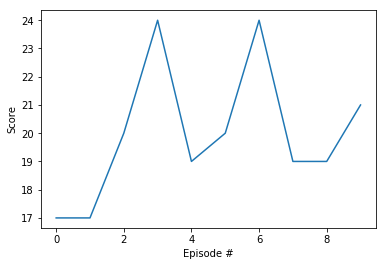

In [4]:
file_name = 'checkpoint_final.pth'
torch.save(agent.local_network.state_dict(), file_name)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(results)), results)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
fig.set_size_inches(18.5, 10.5)
fig.savefig('result.png', dpi=100)

In [23]:
agent = DQN_agent(len(actions), device, writer, is_dueling=True)
agent.predict_network.load_state_dict(torch.load('C:/Users/Marcin i Ewa/doom_DQL/Doom/DQN + priorityReplay/checkpoint_final.pth'))

cx = Variable(torch.zeros(1, 40, device=device)) # the cell states of the LSTM are reinitialized to zero
hx = Variable(torch.zeros(1, 40, device=device)) # the hidden states of the LSTM are reinitialized to 

for episode in range(10):
    game.new_episode()
    images = []
    while True:
        state = game.get_state()
        img = state.screen_buffer
        img = preprocess_frame(img)
        misc = state.game_variables
        selected_action = agent.select_action(img, 0., (hx, cx))
        action = actions[selected_action]
        reward = game.make_action(action)
        done = game.is_episode_finished()
        if done:
            break
        state = game.get_state()
        time.sleep(0.01)
    print('Episode: \t{} \tScore: \t{:.2f}'.format(episode, game.get_total_reward()))

Creating dueling network
Episode: 	0 	Score: 	23.00
Episode: 	1 	Score: 	23.00
Episode: 	2 	Score: 	23.00
Episode: 	3 	Score: 	23.00
Episode: 	4 	Score: 	22.00
Episode: 	5 	Score: 	23.00
Episode: 	6 	Score: 	23.00
Episode: 	7 	Score: 	23.00
Episode: 	8 	Score: 	23.00
Episode: 	9 	Score: 	23.00
